In [0]:
# text_split = []
# for i in range(len(train_text)):
#   text_split.append(train_text[i].split())

# train_text = convert(train_text[0])

In [0]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torch.optim import Adam, SGD

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [0]:
par2_path = '/content/drive/My Drive/Part2'
trai_path = '/content/drive/My Drive/Part2/train.csv'
test_path = '/content/drive/My Drive/Part2/test.csv'
vali_path = '/content/drive/My Drive/Part2/validation.csv'
subm_path = '/content/drive/My Drive/Part2/submission.csv'

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Current device:', device)

Current device: cuda:0


In [71]:
from torchtext import *
from torchtext.data import *

import nltk
nltk.download('punkt')
from nltk import word_tokenize

txt_field = data.Field(tokenize=word_tokenize, lower=True, include_lengths=True, batch_first=True)
label_field = data.Field(sequential=False, use_vocab=False, batch_first=True)

# make splits for data
train_d, test_d, valid_d = TabularDataset.splits(path=par2_path, train=trai_path, test=test_path, validation=vali_path, format='csv', 
                                  fields=[('label', label_field), ('sentence', txt_field)], skip_header=True)

# build the vocabulary on the training set only
txt_field.build_vocab(train_d, min_freq=3)
label_field.build_vocab(train_d)

# make iterator for splits
train_iter, test_iter, valid_iter = data.BucketIterator.splits((train_d, test_d, valid_d), batch_size=32, 
                                                   sort_key=lambda x: len(x.sentence),sort_within_batch=True, device=device)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


BASELINE MODEL(TRAINING)
-------------------------------------------------------

In [0]:
class Text_RNN(nn.Module):
    def __init__(self, size_of_vocab, embedding_dim, hidden_dim, num_layers, dropout_d, batch_first):
        super().__init__()
        self.emb = nn.Embedding(size_of_vocab, embedding_dim)
        self.rnn = nn.RNN(
                embedding_dim,
                hidden_dim,
                num_layers,
                dropout=dropout_d,
                batch_first=True
        )
        self.dropout = nn.Dropout(dropout_d)
        self.fc = nn.Linear(hidden_dim * 2, 1)
        self.act = nn.Sigmoid()

    def forward(self, sent, sent_len):
        
        sent_emb = self.emb(sent)
        send_emb = self.dropout(sent_emb)
        packed_embedded = nn.utils.rnn.pack_padded_sequence(sent_emb, sent_len, batch_first=True)
        packed_outputs, hidden = self.rnn(packed_embedded)
        hidden = torch.cat((hidden[-1,:,:], hidden[-1,:,:]), dim = 1)
        dense_outputs=self.fc(hidden)
        outputs=self.act(dense_outputs)

        return outputs

In [41]:
size_of_vocab = len(txt_field.vocab)
embedding_dim = 64
num_hidden = 128
num_layers = 1
dropout_d = 0.5

RNN_model = Text_RNN(size_of_vocab, embedding_dim, num_hidden, num_layers, dropout_d, batch_first=True)
optimizer = optim.Adam(RNN_model.parameters())
RNN_model = RNN_model.to(device)


def count_parameters(RNN_model):
    temp = sum(p.numel() for p in RNN_model.parameters() if p.requires_grad)
    print(f'The RNN_model architecture:\n\n', RNN_model)
    print(f'\nThe RNN_model has {temp:,} trainable parameters')
    
count_parameters(RNN_model)

The RNN_model architecture:

 Text_RNN(
  (emb): Embedding(51167, 64)
  (rnn): RNN(64, 128, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (act): Sigmoid()
)

The RNN_model has 3,299,777 trainable parameters


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [0]:
import torch.optim as optim
criterion = nn.MSELoss()

In [0]:
#define metric
def binary_accuracy(preds, y):
    #round predictions to the closest integer
    rounded_preds = torch.round(preds)
    
    correct = (rounded_preds == y).float() 
    acc = correct.sum() / len(correct)
    return acc
    
#push to cuda if available
criterion = criterion.to(device)

In [0]:
def train(model, iterator, optimizer, criterion):
    
    #initialize every epoch 
    epoch_loss = 0
    epoch_acc = 0
    
    #set the model in training phase
    model.train()  
    
    for batch in iterator:
        
        #resets the gradients after every batch
        optimizer.zero_grad()   
        
        #retrieve text and no. of words
        sent, sent_len = batch.sentence   
        
        #convert to 1D tensor
        predictions = model(sent, sent_len).squeeze()
        
        #compute the loss
        loss = criterion(predictions.float(), batch.label.float())      
        
        #compute the binary accuracy
        acc = binary_accuracy(predictions, batch.label)   
        
        #backpropage the loss and compute the gradients
        loss.backward()
        
        #update the weights
        optimizer.step()      
        
        #loss and accuracy
        epoch_loss += loss.item()  
        epoch_acc += acc.item()    
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [0]:
def evaluate(model, iterator, criterion):
    
    #initialize every epoch
    epoch_loss = 0
    epoch_acc = 0

    #deactivating dropout layers
    model.eval()
    
    #deactivates autograd
    with torch.no_grad():
    
        for batch in iterator:
        
            #retrieve text and no. of words
            sent, sent_len = batch.sentence
            
            #convert to 1d tensor
            predictions = model(sent, sent_len).squeeze()
            
            #compute loss and accuracy
            loss = criterion(predictions, batch.label)
            acc = binary_accuracy(predictions, batch.label)
            
            #keep track of loss and accuracy
            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [0]:
N_EPOCHS = 10
best_valid_loss = float('inf')

Time = []
TrainLoss = []
ValidLoss = []
TrainAccu = []
ValidAccu = []

for epoch in range(N_EPOCHS):
     
    #train the model
    train_loss, train_acc = train(RNN_model, train_iter, optimizer, criterion)
    
    #evaluate the model
    valid_loss, valid_acc = train(RNN_model, valid_iter, optimizer, criterion)
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(RNN_model.state_dict(), 'saved_weights.pt')

    Time.append(epoch)
    TrainLoss.append(train_loss)
    ValidLoss.append(valid_loss)
    TrainAccu.append(train_acc)
    ValidAccu.append(valid_acc)

    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

	Train Loss: 0.238 | Train Acc: 58.47%
	 Val. Loss: 0.211 |  Val. Acc: 67.14%
	Train Loss: 0.218 | Train Acc: 65.03%
	 Val. Loss: 0.211 |  Val. Acc: 68.16%
	Train Loss: 0.212 | Train Acc: 65.75%
	 Val. Loss: 0.217 |  Val. Acc: 65.14%
	Train Loss: 0.196 | Train Acc: 70.65%
	 Val. Loss: 0.177 |  Val. Acc: 74.42%
	Train Loss: 0.180 | Train Acc: 73.78%
	 Val. Loss: 0.205 |  Val. Acc: 71.42%
	Train Loss: 0.202 | Train Acc: 68.91%
	 Val. Loss: 0.206 |  Val. Acc: 69.04%
	Train Loss: 0.174 | Train Acc: 74.86%
	 Val. Loss: 0.188 |  Val. Acc: 71.37%
	Train Loss: 0.179 | Train Acc: 73.58%
	 Val. Loss: 0.175 |  Val. Acc: 74.89%
	Train Loss: 0.144 | Train Acc: 79.88%
	 Val. Loss: 0.145 |  Val. Acc: 79.74%
	Train Loss: 0.171 | Train Acc: 75.47%
	 Val. Loss: 0.150 |  Val. Acc: 77.80%


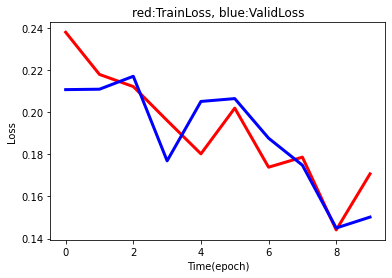

In [0]:
plt.plot(Time, TrainLoss, color='red', linewidth=3)
plt.plot(Time, ValidLoss, color='blue', linewidth=3)
plt.axis
plt.title('red:TrainLoss, blue:ValidLoss')
plt.xlabel('Time(epoch)')
plt.ylabel('Loss')
plt.show()

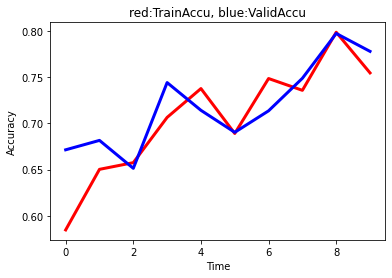

In [0]:
plt.plot(Time, TrainAccu, color='red', linewidth=3)
plt.plot(Time, ValidAccu, color='blue', linewidth=3)
plt.axis
plt.title('red:TrainAccu, blue:ValidAccu')
plt.xlabel('Time')
plt.ylabel('Accuracy')
plt.show()

BASELINE MODEL(TESTING)
-------------------------------------------------------

In [0]:
N_EPOCHS = 10
best_valid_loss = float('inf')

Time = []
TestAccu = []
TrainAccu = []
ValidAccu = []
TestLoss = []
TrainLoss = []
ValidLoss = []

for epoch in range(N_EPOCHS):
     
    #train the model
    test_loss, test_acc = train(RNN_model, test_iter, optimizer, criterion)
    train_loss, train_acc = train(RNN_model, train_iter, optimizer, criterion)
    valid_loss, valid_acc = train(RNN_model, valid_iter, optimizer, criterion)

    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(RNN_model.state_dict(), 'saved_weights.pt')

    Time.append(epoch)
    TrainLoss.append(train_loss)
    ValidLoss.append(valid_loss)
    TestLoss.append(test_loss)
    TrainAccu.append(train_acc)
    ValidAccu.append(valid_acc)
    TestAccu.append(test_acc)

    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
    print(f'\tTest Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

	Train Loss: 0.232 | Train Acc: 60.07%
	 Val. Loss: 0.208 |  Val. Acc: 67.52%
	Test Loss: 0.249 | Test Acc: 53.88%
	Train Loss: 0.222 | Train Acc: 63.51%
	 Val. Loss: 0.211 |  Val. Acc: 67.08%
	Test Loss: 0.212 | Test Acc: 66.12%
	Train Loss: 0.224 | Train Acc: 62.50%
	 Val. Loss: 0.176 |  Val. Acc: 75.65%
	Test Loss: 0.248 | Test Acc: 53.70%
	Train Loss: 0.176 | Train Acc: 74.42%
	 Val. Loss: 0.228 |  Val. Acc: 61.14%
	Test Loss: 0.178 | Test Acc: 74.34%
	Train Loss: 0.175 | Train Acc: 74.13%
	 Val. Loss: 0.169 |  Val. Acc: 74.87%
	Test Loss: 0.226 | Test Acc: 62.10%
	Train Loss: 0.177 | Train Acc: 73.26%
	 Val. Loss: 0.200 |  Val. Acc: 68.42%
	Test Loss: 0.166 | Test Acc: 76.71%
	Train Loss: 0.169 | Train Acc: 75.38%
	 Val. Loss: 0.141 |  Val. Acc: 80.70%
	Test Loss: 0.211 | Test Acc: 66.22%
	Train Loss: 0.132 | Train Acc: 82.07%
	 Val. Loss: 0.122 |  Val. Acc: 83.59%
	Test Loss: 0.145 | Test Acc: 80.49%
	Train Loss: 0.134 | Train Acc: 81.57%
	 Val. Loss: 0.127 |  Val. Acc: 83.10%
	T

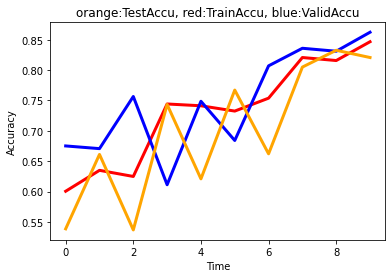

In [0]:
plt.plot(Time, TrainAccu, color='red', linewidth=3)
plt.plot(Time, ValidAccu, color='blue', linewidth=3)
plt.plot(Time, TestAccu, color='orange', linewidth=3)
plt.axis
plt.title('orange:TestAccu, red:TrainAccu, blue:ValidAccu')
plt.xlabel('Time')
plt.ylabel('Accuracy')
plt.show()

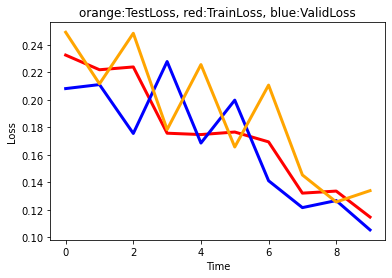

In [0]:
plt.plot(Time, TrainLoss, color='red', linewidth=3)
plt.plot(Time, ValidLoss, color='blue', linewidth=3)
plt.plot(Time, TestLoss, color='orange', linewidth=3)
plt.axis
plt.title('orange:TestLoss, red:TrainLoss, blue:ValidLoss')
plt.xlabel('Time')
plt.ylabel('Loss')
plt.show()

4MODELS
-------------------------------------
---------------------------------------

MODEL1 - GRU

In [0]:
class Text_GRU(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_output, num_layers, dropout_d, bidirectional):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.GRU(embedding_dim, 
                           hidden_dim, 
                           num_layers, 
                           bidirectional=bidirectional, 
                           dropout=dropout_d,
                           batch_first=True)
        
        self.fc = nn.Linear(hidden_dim, num_output)
        self.act = nn.Sigmoid()

    def forward(self, sent, sent_len):

        sent_emb = self.emb(sent)
        packed_embedded = nn.utils.rnn.pack_padded_sequence(sent_emb, sent_len, batch_first=True)
        packed_outputs, (hidden, cell) = self.lstm(packed_embedded)
        dense_outputs=self.fc(hidden)
        outputs=self.act(dense_outputs)

        return outputs

In [57]:
size_of_vocab = len(txt_field.vocab)
embedding_dim = 64
num_hidden = 128
num_output = 1
num_layers = 1
dropout_d = 0.5

Model1 = Text_GRU(size_of_vocab, embedding_dim, num_hidden,num_output, num_layers, dropout_d, bidirectional = True)
optimizer = optim.Adam(Model1.parameters())
Model1 = Model1.to(device)

def count_parameters(Model1):
    temp = sum(p.numel() for p in Model1.parameters() if p.requires_grad)
    print(f'The Model1 architecture:\n\n', Model1)
    print(f'\nThe Model1 has {temp:,} trainable parameters')
    
count_parameters(Model1)

The Model1 architecture:

 Text_GRU(
  (emb): Embedding(51167, 64)
  (lstm): GRU(64, 128, batch_first=True, dropout=0.5, bidirectional=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (act): Sigmoid()
)

The Model1 has 3,423,809 trainable parameters


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [0]:
N_EPOCHS = 10
best_valid_loss = float('inf')

Time = []
TrainLoss = []
ValidLoss = []
TrainAccu = []
ValidAccu = []

for epoch in range(N_EPOCHS):
     

    train_loss, train_acc = train(Model1, train_iter, optimizer, criterion)
    valid_loss, valid_acc = train(Model1, valid_iter, optimizer, criterion)
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(Model1.state_dict(), 'saved_weights.pt')

    Time.append(epoch)
    TrainLoss.append(train_loss)
    ValidLoss.append(valid_loss)
    TrainAccu.append(train_acc)
    ValidAccu.append(valid_acc)

    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

	Train Loss: 0.188 | Train Acc: 70.03%
	 Val. Loss: 0.100 |  Val. Acc: 85.99%
	Train Loss: 0.077 | Train Acc: 89.66%
	 Val. Loss: 0.066 |  Val. Acc: 90.97%
	Train Loss: 0.051 | Train Acc: 93.45%
	 Val. Loss: 0.048 |  Val. Acc: 93.95%
	Train Loss: 0.035 | Train Acc: 95.70%
	 Val. Loss: 0.037 |  Val. Acc: 95.57%
	Train Loss: 0.024 | Train Acc: 97.21%
	 Val. Loss: 0.027 |  Val. Acc: 96.44%
	Train Loss: 0.018 | Train Acc: 97.99%
	 Val. Loss: 0.022 |  Val. Acc: 97.47%
	Train Loss: 0.014 | Train Acc: 98.48%
	 Val. Loss: 0.015 |  Val. Acc: 98.24%
	Train Loss: 0.012 | Train Acc: 98.72%
	 Val. Loss: 0.013 |  Val. Acc: 98.60%
	Train Loss: 0.011 | Train Acc: 98.87%
	 Val. Loss: 0.014 |  Val. Acc: 98.57%
	Train Loss: 0.010 | Train Acc: 98.89%
	 Val. Loss: 0.011 |  Val. Acc: 98.77%


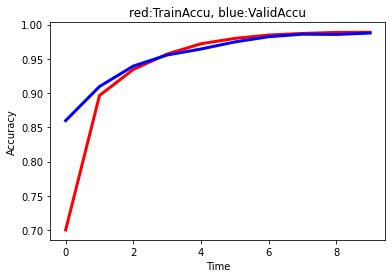

In [0]:
plt.plot(Time, TrainAccu, color='red', linewidth=3)
plt.plot(Time, ValidAccu, color='blue', linewidth=3)
plt.axis
plt.title('red:TrainAccu, blue:ValidAccu')
plt.xlabel('Time')
plt.ylabel('Accuracy')
plt.show()

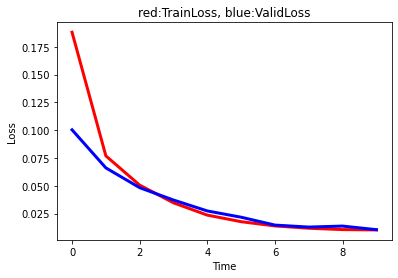

In [0]:
plt.plot(Time, TrainLoss, color='red', linewidth=3)
plt.plot(Time, ValidLoss, color='blue', linewidth=3)
plt.axis
plt.title('red:TrainLoss, blue:ValidLoss')
plt.xlabel('Time')
plt.ylabel('Loss')
plt.show()

MODEL2 - LSTM(bi=no, em=yes)

In [0]:
class Text_LSTM1(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, num_layers, dropout_d, bidirectional):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           num_layers, 
                           bidirectional=False, 
                           dropout=dropout_d,
                           batch_first=True)
        
        self.dropout = nn.Dropout(dropout_d)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.act = nn.Sigmoid()

    def forward(self, sent, sent_len):

        
        sent_emb = self.emb(sent)
        send_emb = self.dropout(sent_emb)
        packed_embedded = nn.utils.rnn.pack_padded_sequence(sent_emb, sent_len, batch_first=True)
        packed_outputs, (hidden, cell) = self.lstm(packed_embedded)
        dense_outputs=self.fc(hidden)
        outputs=self.act(dense_outputs)

        return outputs
        

In [65]:
size_of_vocab = len(txt_field.vocab)
embedding_dim = 64
num_hidden = 128
num_output = 1
num_layers = 1
dropout_d = 0.5

Model2 = Text_LSTM1(size_of_vocab, embedding_dim, num_hidden,num_output, num_layers, dropout_d, bidirectional=False)
optimizer = optim.Adam(Model2.parameters())
Model2 = Model2.to(device)

def count_parameters(Model2):
    temp = sum(p.numel() for p in Model2.parameters() if p.requires_grad)
    print(f'The Model2 architecture:\n\n', Model2)
    print(f'\nThe Model2 has {temp:,} trainable parameters')
    
count_parameters(Model2)

The Model2 architecture:

 Text_LSTM1(
  (emb): Embedding(51167, 64)
  (lstm): LSTM(64, 128, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (act): Sigmoid()
)

The Model2 has 3,374,145 trainable parameters


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [0]:
N_EPOCHS = 10
best_valid_loss = float('inf')

Time = []
TrainLoss = []
ValidLoss = []
TrainAccu = []
ValidAccu = []

for epoch in range(N_EPOCHS):
     

    train_loss, train_acc = train(Model2, train_iter, optimizer, criterion)
    valid_loss, valid_acc = train(Model2, valid_iter, optimizer, criterion)
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(Model2.state_dict(), 'saved_weights.pt')

    Time.append(epoch)
    TrainLoss.append(train_loss)
    ValidLoss.append(valid_loss)
    TrainAccu.append(train_acc)
    ValidAccu.append(valid_acc)

    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

	Train Loss: 0.211 | Train Acc: 66.14%
	 Val. Loss: 0.170 |  Val. Acc: 76.47%
	Train Loss: 0.136 | Train Acc: 81.25%
	 Val. Loss: 0.107 |  Val. Acc: 85.37%
	Train Loss: 0.094 | Train Acc: 87.45%
	 Val. Loss: 0.122 |  Val. Acc: 83.27%
	Train Loss: 0.075 | Train Acc: 90.27%
	 Val. Loss: 0.094 |  Val. Acc: 88.57%
	Train Loss: 0.056 | Train Acc: 93.00%
	 Val. Loss: 0.056 |  Val. Acc: 92.82%
	Train Loss: 0.041 | Train Acc: 95.04%
	 Val. Loss: 0.045 |  Val. Acc: 94.41%
	Train Loss: 0.031 | Train Acc: 96.25%
	 Val. Loss: 0.038 |  Val. Acc: 95.45%
	Train Loss: 0.024 | Train Acc: 97.30%
	 Val. Loss: 0.033 |  Val. Acc: 96.32%
	Train Loss: 0.019 | Train Acc: 97.86%
	 Val. Loss: 0.028 |  Val. Acc: 96.94%
	Train Loss: 0.016 | Train Acc: 98.20%
	 Val. Loss: 0.024 |  Val. Acc: 97.27%


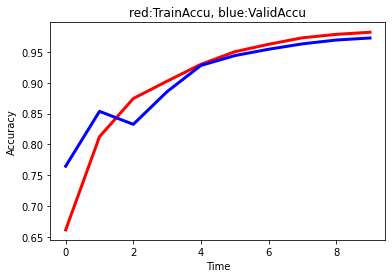

In [0]:
plt.plot(Time, TrainAccu, color='red', linewidth=3)
plt.plot(Time, ValidAccu, color='blue', linewidth=3)
plt.axis
plt.title('red:TrainAccu, blue:ValidAccu')
plt.xlabel('Time')
plt.ylabel('Accuracy')
plt.show()

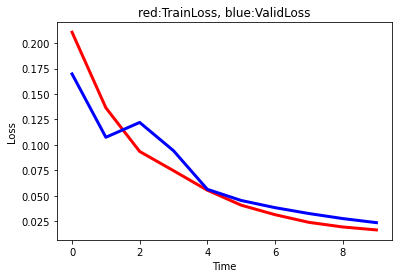

In [0]:
plt.plot(Time, TrainLoss, color='red', linewidth=3)
plt.plot(Time, ValidLoss, color='blue', linewidth=3)
plt.axis
plt.title('red:TrainLoss, blue:ValidLoss')
plt.xlabel('Time')
plt.ylabel('Loss')
plt.show()

MODEL3 - LSTM(bi=yes, em=yes)

In [0]:
class Text_LSTM2(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, num_layers, dropout_d, bidirectional):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           num_layers, 
                           bidirectional=True, 
                           dropout=dropout_d,
                           batch_first=True)
        
        self.dropout = nn.Dropout(dropout_d)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.act = nn.Sigmoid()

    def forward(self, sent, sent_len):

        
        sent_emb = self.emb(sent)
        send_emb = self.dropout(sent_emb)
        packed_embedded = nn.utils.rnn.pack_padded_sequence(sent_emb, sent_len, batch_first=True)
        packed_outputs, (hidden, cell) = self.lstm(packed_embedded)
        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)
        dense_outputs=self.fc(hidden)
        outputs=self.act(dense_outputs)

        return outputs
        

In [74]:
size_of_vocab = len(txt_field.vocab)
embedding_dim = 64
num_hidden = 128
num_output = 1
num_layers = 1
dropout_d = 0.5

Model3 = Text_LSTM2(size_of_vocab, embedding_dim, num_hidden,num_output, num_layers, dropout_d, bidirectional=True)
optimizer = optim.Adam(Model3.parameters())
Model3 = Model3.to(device)

def count_parameters(Model3):
    temp = sum(p.numel() for p in Model3.parameters() if p.requires_grad)
    print(f'The Model3 architecture:\n\n', Model3)
    print(f'\nThe Model3 has {temp:,} trainable parameters')
    
count_parameters(Model3)

The Model3 architecture:

 Text_LSTM2(
  (emb): Embedding(51167, 64)
  (lstm): LSTM(64, 128, batch_first=True, dropout=0.5, bidirectional=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (act): Sigmoid()
)

The Model3 has 3,473,601 trainable parameters


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [0]:
N_EPOCHS = 10
best_valid_loss = float('inf')

Time = []
TrainLoss = []
ValidLoss = []
TrainAccu = []
ValidAccu = []

for epoch in range(N_EPOCHS):
     

    train_loss, train_acc = train(Model3, train_iter, optimizer, criterion)
    valid_loss, valid_acc = train(Model3, valid_iter, optimizer, criterion)
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(Model3.state_dict(), 'saved_weights.pt')

    Time.append(epoch)
    TrainLoss.append(train_loss)
    ValidLoss.append(valid_loss)
    TrainAccu.append(train_acc)
    ValidAccu.append(valid_acc)

    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

	Train Loss: 0.198 | Train Acc: 69.33%
	 Val. Loss: 0.182 |  Val. Acc: 73.88%
	Train Loss: 0.162 | Train Acc: 76.51%
	 Val. Loss: 0.113 |  Val. Acc: 84.50%
	Train Loss: 0.083 | Train Acc: 88.74%
	 Val. Loss: 0.074 |  Val. Acc: 90.08%
	Train Loss: 0.056 | Train Acc: 92.84%
	 Val. Loss: 0.055 |  Val. Acc: 92.93%
	Train Loss: 0.040 | Train Acc: 95.09%
	 Val. Loss: 0.039 |  Val. Acc: 95.21%
	Train Loss: 0.029 | Train Acc: 96.62%
	 Val. Loss: 0.028 |  Val. Acc: 96.81%
	Train Loss: 0.021 | Train Acc: 97.69%
	 Val. Loss: 0.022 |  Val. Acc: 97.61%
	Train Loss: 0.016 | Train Acc: 98.26%
	 Val. Loss: 0.022 |  Val. Acc: 97.37%
	Train Loss: 0.013 | Train Acc: 98.63%
	 Val. Loss: 0.015 |  Val. Acc: 98.04%
	Train Loss: 0.011 | Train Acc: 98.84%
	 Val. Loss: 0.013 |  Val. Acc: 98.60%


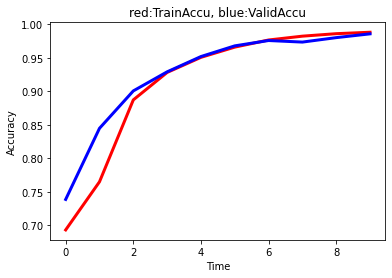

In [0]:
plt.plot(Time, TrainAccu, color='red', linewidth=3)
plt.plot(Time, ValidAccu, color='blue', linewidth=3)
plt.axis
plt.title('red:TrainAccu, blue:ValidAccu')
plt.xlabel('Time')
plt.ylabel('Accuracy')
plt.show()

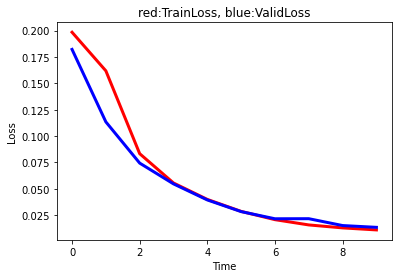

In [0]:
plt.plot(Time, TrainLoss, color='red', linewidth=3)
plt.plot(Time, ValidLoss, color='blue', linewidth=3)
plt.axis
plt.title('red:TrainLoss, blue:ValidLoss')
plt.xlabel('Time')
plt.ylabel('Loss')
plt.show()

MODEL4 - LSTM(bi=no, em=no)

In [0]:
class Text_LSTM3(nn.Module):
    def __init__(self, vocab_size, hidden_dim, output_dim, num_layers, dropout_d):
        super(Text_LSTM3, self).__init__()
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        self.input_size = vocab_size
        self.n_embed = 1
        self.rnn = nn.LSTM(
                           input_size = self.n_embed,
                           hidden_size = hidden_dim, 
                           num_layers = num_layers,  
                           dropout=dropout_d,
                           batch_first=True)
        
        self.dropout = nn.Dropout(dropout_d)
        self.fc1 = nn.Linear(hidden_dim, output_dim)
        self.act = nn.Sigmoid()

    def forward(self, sent, sent_len):
        unembed_sent = sent.view(sent.size(0),-1,self.n_embed).float()
        _, outputs = self.rnn(unembed_sent)
        outputs = outputs[:,-1,:]
        outputs = self.act(self.fc(self.dropout(outputs)))
        # padded = nn.utils.rnn.pack_padded_sequence(sent.unsqueeze(0), sent_len, batch_first=True)
        # packed_outputs, (hidden, cell) = self.lstm(sent)
        # hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)
        # send_emb = self.dropout(packed_outputs)
        # dense_outputs = self.fc1(send_emb)
        # outputs=self.act(dense_outputs)

        return outputs
        

In [36]:
size_of_vocab = len(txt_field.vocab)

num_hidden = 128
num_output = 1
num_layers = 1
dropout_d = 0.5

Model4 = Text_LSTM3(size_of_vocab, num_hidden,num_output, num_layers, dropout_d)
optimizer = optim.Adam(Model4.parameters())
Model4 = Model4.to(device)

def count_parameters(Model4):
    temp = sum(p.numel() for p in Model4.parameters() if p.requires_grad)
    print(f'The Model4 architecture:\n\n', Model4)
    print(f'\nThe Model4 has {temp:,} trainable parameters')
    
count_parameters(Model4)

The Model4 architecture:

 Text_LSTM3(
  (rnn): LSTM(1, 128, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=128, out_features=1, bias=True)
  (act): Sigmoid()
)

The Model4 has 67,201 trainable parameters


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [0]:
N_EPOCHS = 10
best_valid_loss = float('inf')

Time = []
TrainLoss = []
ValidLoss = []
TrainAccu = []
ValidAccu = []
for epoch in range(N_EPOCHS):
     

    train_loss, train_acc = train(Model4, train_iter, optimizer, criterion)
    valid_loss, valid_acc = train(Model4, valid_iter, optimizer, criterion)
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(Model4.state_dict(), 'saved_weights.pt')

    Time.append(epoch)
    TrainLoss.append(train_loss)
    ValidLoss.append(valid_loss)
    TrainAccu.append(train_acc)
    ValidAccu.append(valid_acc)

    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

In [0]:
baseline model, model 1 and model
2 in one plot.

Baseline model vs Model1 vs Model2

In [46]:
N_EPOCHS = 10
best_valid_loss = float('inf')

Time = []
TrainLoss_base = []
ValidLoss_base = []
TrainAccu_base = []
ValidAccu_base = []

for epoch in range(N_EPOCHS):
     

    train_loss, train_acc = train(RNN_model, train_iter, optimizer, criterion)
    valid_loss, valid_acc = train(RNN_model, valid_iter, optimizer, criterion)
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(RNN_model.state_dict(), 'saved_weights.pt')

    Time.append(epoch)
    TrainLoss_base.append(train_loss)
    ValidLoss_base.append(valid_loss)
    TrainAccu_base.append(train_acc)
    ValidAccu_base.append(valid_acc)

    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')


	Train Loss: 0.238 | Train Acc: 58.54%
	 Val. Loss: 0.248 |  Val. Acc: 53.71%
	Train Loss: 0.226 | Train Acc: 62.26%
	 Val. Loss: 0.217 |  Val. Acc: 64.89%
	Train Loss: 0.211 | Train Acc: 66.56%
	 Val. Loss: 0.209 |  Val. Acc: 66.32%
	Train Loss: 0.191 | Train Acc: 70.89%
	 Val. Loss: 0.227 |  Val. Acc: 61.97%
	Train Loss: 0.189 | Train Acc: 71.01%
	 Val. Loss: 0.178 |  Val. Acc: 73.69%
	Train Loss: 0.162 | Train Acc: 76.74%
	 Val. Loss: 0.144 |  Val. Acc: 80.70%
	Train Loss: 0.172 | Train Acc: 74.64%
	 Val. Loss: 0.174 |  Val. Acc: 73.60%
	Train Loss: 0.142 | Train Acc: 80.26%
	 Val. Loss: 0.146 |  Val. Acc: 78.72%
	Train Loss: 0.142 | Train Acc: 80.08%
	 Val. Loss: 0.139 |  Val. Acc: 81.21%
	Train Loss: 0.130 | Train Acc: 82.23%
	 Val. Loss: 0.137 |  Val. Acc: 80.70%


In [61]:
N_EPOCHS = 10
best_valid_loss = float('inf')

Time = []
TrainLoss_Model1 = []
ValidLoss_Model1 = []
TrainAccu_Model1 = []
ValidAccu_Model1 = []

for epoch in range(N_EPOCHS):
     

    train_loss, train_acc = train(Model1, train_iter, optimizer, criterion)
    valid_loss, valid_acc = train(Model1, valid_iter, optimizer, criterion)
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(Model1.state_dict(), 'saved_weights.pt')

    Time.append(epoch)
    TrainLoss_Model1.append(train_loss)
    ValidLoss_Model1.append(valid_loss)
    TrainAccu_Model1.append(train_acc)
    ValidAccu_Model1.append(valid_acc)

    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

	Train Loss: 0.182 | Train Acc: 71.92%
	 Val. Loss: 0.117 |  Val. Acc: 83.26%
	Train Loss: 0.083 | Train Acc: 88.87%
	 Val. Loss: 0.069 |  Val. Acc: 90.56%
	Train Loss: 0.055 | Train Acc: 92.93%
	 Val. Loss: 0.047 |  Val. Acc: 94.19%
	Train Loss: 0.039 | Train Acc: 95.32%
	 Val. Loss: 0.035 |  Val. Acc: 95.51%
	Train Loss: 0.027 | Train Acc: 96.78%
	 Val. Loss: 0.028 |  Val. Acc: 96.54%
	Train Loss: 0.020 | Train Acc: 97.70%
	 Val. Loss: 0.022 |  Val. Acc: 97.41%
	Train Loss: 0.017 | Train Acc: 98.11%
	 Val. Loss: 0.015 |  Val. Acc: 98.50%
	Train Loss: 0.013 | Train Acc: 98.63%
	 Val. Loss: 0.015 |  Val. Acc: 98.30%
	Train Loss: 0.011 | Train Acc: 98.77%
	 Val. Loss: 0.014 |  Val. Acc: 98.54%
	Train Loss: 0.010 | Train Acc: 98.86%
	 Val. Loss: 0.014 |  Val. Acc: 98.37%


In [69]:
N_EPOCHS = 10
best_valid_loss = float('inf')

Time = []
TrainLoss_Model2 = []
ValidLoss_Model2 = []
TrainAccu_Model2 = []
ValidAccu_Model2 = []

for epoch in range(N_EPOCHS):
     

    train_loss, train_acc = train(Model2, train_iter, optimizer, criterion)
    valid_loss, valid_acc = train(Model2, valid_iter, optimizer, criterion)
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(Model2.state_dict(), 'saved_weights.pt')

    Time.append(epoch)
    TrainLoss_Model2.append(train_loss)
    ValidLoss_Model2.append(valid_loss)
    TrainAccu_Model2.append(train_acc)
    ValidAccu_Model2.append(valid_acc)

    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

	Train Loss: 0.214 | Train Acc: 65.25%
	 Val. Loss: 0.201 |  Val. Acc: 69.55%
	Train Loss: 0.160 | Train Acc: 76.63%
	 Val. Loss: 0.107 |  Val. Acc: 85.11%
	Train Loss: 0.083 | Train Acc: 88.94%
	 Val. Loss: 0.068 |  Val. Acc: 91.29%
	Train Loss: 0.058 | Train Acc: 92.55%
	 Val. Loss: 0.058 |  Val. Acc: 92.43%
	Train Loss: 0.043 | Train Acc: 94.65%
	 Val. Loss: 0.038 |  Val. Acc: 95.48%
	Train Loss: 0.031 | Train Acc: 96.23%
	 Val. Loss: 0.028 |  Val. Acc: 96.64%
	Train Loss: 0.024 | Train Acc: 97.25%
	 Val. Loss: 0.024 |  Val. Acc: 97.21%
	Train Loss: 0.019 | Train Acc: 97.86%
	 Val. Loss: 0.022 |  Val. Acc: 97.71%
	Train Loss: 0.014 | Train Acc: 98.45%
	 Val. Loss: 0.019 |  Val. Acc: 98.07%
	Train Loss: 0.013 | Train Acc: 98.64%
	 Val. Loss: 0.016 |  Val. Acc: 98.40%


In [78]:
N_EPOCHS = 10
best_valid_loss = float('inf')

Time = []
TrainLoss_Model3 = []
ValidLoss_Model3 = []
TrainAccu_Model3 = []
ValidAccu_Model3 = []

for epoch in range(N_EPOCHS):
     

    train_loss, train_acc = train(Model3, train_iter, optimizer, criterion)
    valid_loss, valid_acc = train(Model3, valid_iter, optimizer, criterion)
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(Model3.state_dict(), 'saved_weights.pt')

    Time.append(epoch)
    TrainLoss_Model3.append(train_loss)
    ValidLoss_Model3.append(valid_loss)
    TrainAccu_Model3.append(train_acc)
    ValidAccu_Model3.append(valid_acc)

    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

	Train Loss: 0.198 | Train Acc: 68.86%
	 Val. Loss: 0.151 |  Val. Acc: 78.63%
	Train Loss: 0.137 | Train Acc: 80.58%
	 Val. Loss: 0.102 |  Val. Acc: 85.92%
	Train Loss: 0.079 | Train Acc: 89.26%
	 Val. Loss: 0.079 |  Val. Acc: 89.63%
	Train Loss: 0.061 | Train Acc: 92.01%
	 Val. Loss: 0.059 |  Val. Acc: 92.52%
	Train Loss: 0.046 | Train Acc: 94.18%
	 Val. Loss: 0.046 |  Val. Acc: 94.22%
	Train Loss: 0.033 | Train Acc: 96.02%
	 Val. Loss: 0.032 |  Val. Acc: 96.44%
	Train Loss: 0.026 | Train Acc: 96.95%
	 Val. Loss: 0.026 |  Val. Acc: 97.01%
	Train Loss: 0.019 | Train Acc: 97.95%
	 Val. Loss: 0.021 |  Val. Acc: 97.67%
	Train Loss: 0.014 | Train Acc: 98.47%
	 Val. Loss: 0.020 |  Val. Acc: 97.81%
	Train Loss: 0.012 | Train Acc: 98.64%
	 Val. Loss: 0.016 |  Val. Acc: 98.27%


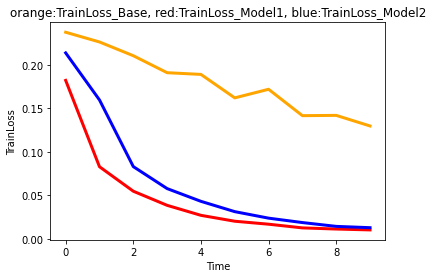

In [81]:
plt.plot(Time, TrainLoss_Model1, color='red', linewidth=3)
plt.plot(Time, TrainLoss_Model2, color='blue', linewidth=3)
plt.plot(Time, TrainLoss_base, color='orange', linewidth=3)
plt.axis
plt.title('orange:TrainLoss_Base, red:TrainLoss_Model1, blue:TrainLoss_Model2')
plt.xlabel('Time')
plt.ylabel('TrainLoss')
plt.show()

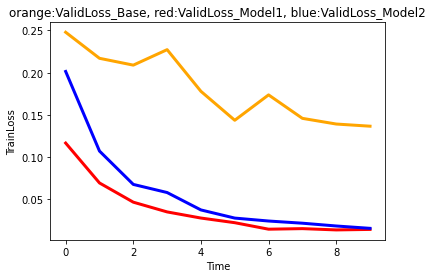

In [83]:
plt.plot(Time, ValidLoss_Model1, color='red', linewidth=3)
plt.plot(Time, ValidLoss_Model2, color='blue', linewidth=3)
plt.plot(Time, ValidLoss_base, color='orange', linewidth=3)
plt.axis
plt.title('orange:ValidLoss_Base, red:ValidLoss_Model1, blue:ValidLoss_Model2')
plt.xlabel('Time')
plt.ylabel('TrainLoss')
plt.show()

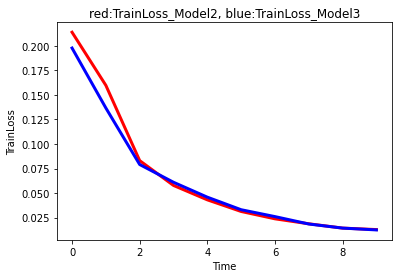

In [84]:
plt.plot(Time, TrainLoss_Model2, color='red', linewidth=3)
plt.plot(Time, TrainLoss_Model3, color='blue', linewidth=3)
plt.axis
plt.title('red:TrainLoss_Model2, blue:TrainLoss_Model3')
plt.xlabel('Time')
plt.ylabel('TrainLoss')
plt.show()

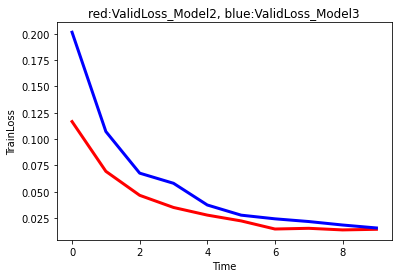

In [85]:
plt.plot(Time, ValidLoss_Model1, color='red', linewidth=3)
plt.plot(Time, ValidLoss_Model2, color='blue', linewidth=3)
plt.axis
plt.title('red:ValidLoss_Model2, blue:ValidLoss_Model3')
plt.xlabel('Time')
plt.ylabel('TrainLoss')
plt.show()

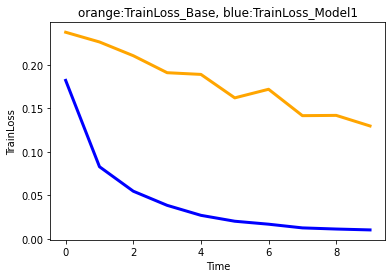

In [87]:
plt.plot(Time, TrainLoss_Model1, color='blue', linewidth=3)
plt.plot(Time, TrainLoss_base, color='orange', linewidth=3)
plt.axis
plt.title('orange:TrainLoss_Base, blue:TrainLoss_Model1')
plt.xlabel('Time')
plt.ylabel('TrainLoss')
plt.show()

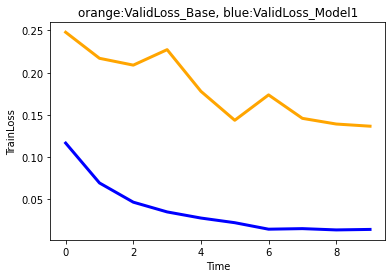

In [88]:
plt.plot(Time, ValidLoss_Model1, color='blue', linewidth=3)
plt.plot(Time, ValidLoss_base, color='orange', linewidth=3)
plt.axis
plt.title('orange:ValidLoss_Base, blue:ValidLoss_Model1')
plt.xlabel('Time')
plt.ylabel('TrainLoss')
plt.show()